# ML21-HW05-Translation(Seq2Seq)

## Introduction

Reference:

- main
    - https://zhuanlan.zhihu.com/p/106902569
    - https://zhuanlan.zhihu.com/p/347061440
    - https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb
    - https://nlp.seas.harvard.edu/2018/04/03/attention.html
    
- utils
    - https://docs.python.org/3/howto/logging.html#logging-basic-tutorial

Architecture:


# Preparing Data

The data has already been downloaded to local. Check original code from TA's for download information.

- Extract the .tgz files `./data/ted2020.tgz` to `./data/raw/`.

- Clean raw data and save the result to `./data/clean/`.


## Unzip `.tgz` File

(These code blocks credit to `shopping le macaca`.)

In [ ]:
import tarfile
from pathlib import Path


src_path = './data/ted2020.tgz'
unzip_dir = './data/raw'
Path(unzip_dir).mkdir(parents=True, exist_ok=True)

with tarfile.open(src_path) as tf:
    tf.extractall(unzip_dir)

In [ ]:
# print some data
with open(unzip_dir + '/raw.en') as en_file:
    en_data = en_file.read().splitlines()
with open(unzip_dir + '/raw.zh') as zh_file:
    zh_data = zh_file.read().splitlines()
for i in range(5):
    print(en_data[i])
    print(zh_data[i])
with open(unzip_dir + '/raw.en') as en_r:
    endata = en_r.readline()
    print(endata)

## Data Preprocessing

- clean data
- save data to `.json` file

In [1]:
import re
from pathlib import Path


class DataPreprocessor:
    """
    Args:
    - en_filepath (:obj:`str`) :
        filepath of raw en-corpus
    - zh_filepath (:obj:`str`) :
        filepath of raw zh-corpus
    - is_test (:obj:`bool` | False) :
        whether the input files are for testing
    - ratio (:obj:`int` | 9) :
        threshold ratio between senctence lengths of en and zh
    - max_len (:obj:`int` | 1000) :
        maximum length of each sentence
    - min_len (:obj:`int` | 1) :
        minimum length of each sentence

    function call:
    - cleans en- and zh-corpus
    - return tuple of lists (en-corpus, zh-corpus)
    """
    def __call__(self, en_filepath : str, zh_filepath : str, is_test=False, ratio=9, max_len=400, min_len=1):
        en_path = Path(en_filepath)
        zh_path = Path(zh_filepath)     
        en_clean_corpus = []
        zh_clean_corpus = []
        # start clean
        if is_test:
            with en_path.open(mode='r') as r:
                for s in r:
                    s = s.strip()
                    s = self.__clean_string__(s, 'en')
                    en_clean_corpus.append(s)
        else:
            with en_path.open(mode='r') as ren:
                with zh_path.open(mode='r') as rzh:
                    for s_en in ren:
                        s_en = s_en.strip()
                        s_zh = rzh.readline().strip()
                        s_en = self.__clean_string__(s_en, 'en')
                        s_zh = self.__clean_string__(s_zh, 'zh')
                        if self.__drop__(
                            self.__get_strlen__(s_en, 'en'),
                            self.__get_strlen__(s_zh, 'zh'),
                            min_len, max_len, ratio):
                            continue
                        en_clean_corpus.append(s_en)
                        zh_clean_corpus.append(s_zh)
        return en_clean_corpus, zh_clean_corpus
    
    def __drop__(self, en_len, zh_len, min_len, max_len, ratio):
        """check whether the input strings pass the given thresholds"""
        if en_len < min_len or zh_len < min_len:
            return True
        if en_len > max_len or zh_len > max_len:
            return True
        if en_len/zh_len > ratio or zh_len/en_len > ratio:
            return True
        return False
    
    def __f2h__(self, fstr : str):
        """convert full-width string to half-width string"""
        # reference: https://www.cnblogs.com/kaituorensheng/p/3554571.html
        # half-width string splitter
        hss = []
        for s in fstr:
            num = ord(s)
            if num == 12288:
                num = 32
            elif 65281 <= num <= 65374:
                num -= 65248
            hss.append(chr(num))
        return ''.join(hss)
    
    def __get_strlen__(self, s : str, lang : str):
        if lang == "zh":
            return len(s)
        return len(s.split())
        
    def __clean_string__(self, s : str, lang : str):
        if lang == 'en':
            s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
            s = s.replace('-', '') # remove '-'
            # Each word in en-string is separated by space, and in order
            #   to keep punctuation for training, we also add space between
            #   word and punctuation.
            # For example,
            #   "hello, this is an example!" becomes
            #   "hello ,  this is an example ! "
            s = re.sub('([.,;:!?()\"])', r" \1 ", s)
            # Continue the above example, the result becomes
            #   "hello , this is an example !"
            s = ' '.join(s.strip().split())
        elif lang == 'zh':
            s = self.__f2h__(s)
            s = re.sub(r"\([^()]*\)", "", s)
            s = s.replace(' ', '')
            s = s.replace('-', '')
            s = s.replace('“', '"')
            s = s.replace('”', '"')
            s = s.replace('_', '')
            # For zh-string, each character is a word, and hence either we
            #   add space between each of the word and punctuation like
            #   we deal with en-string( which will cause a lot of memory waste)
            #   or we deal the zh-string compactly( no sapce between word and punctuation).
            # We choose the second solution, and the example would be
            #   "你好,這是一個例子!"
            #s = re.sub('([。,;:!?()\"~「」])', r' \1 ', s)
            s = s.strip()
        return s
    
def save_data(save_dir, en_corpus, zh_corpus):
    odir = Path(save_dir)
    odir.mkdir(parents=True, exist_ok=True)
    with open(odir / "clean.en", 'w') as ofile:
        for s in en_corpus:
            print(s, file=ofile)
    with open(odir / "clean.zh", 'w') as ofile:
        for s in zh_corpus:
            print(s, file=ofile)
            

In [9]:
# test
dp = DataPreprocessor()
en_corpus, zh_corpus = dp("./data/raw/raw.en", "./data/raw/raw.zh")
for i in range(5):
    print(en_corpus[i])
    print(zh_corpus[i])

# save file to json
save_data("./data/clean", en_corpus, zh_corpus)
# load data for checking
clean_en = []
clean_zh = []
with open("./data/clean/clean.en", 'r') as ifile:
    clean_en = ifile.readlines()
with open("./data/clean/clean.zh", 'r') as ifile:
    clean_zh = ifile.readlines()
print(f"en sentences : {len(clean_en)}")
print(f"zh sentences : {len(clean_zh)}")
for i in range(5):
    print(clean_en[i].strip())
    print(clean_zh[i].strip())

Thank you so much , Chris .
非常謝謝你,克里斯。能有這個機會第二度踏上這個演講台
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
真是一大榮幸。我非常感激。
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
這個研討會給我留下了極為深刻的印象,我想感謝大家對我之前演講的好評。
And I say that sincerely , partly because I need that .
我是由衷的想這麼說,有部份原因是因為——我真的有需要!
Put yourselves in my position .
請你們設身處地為我想一想!
en sentences : 393992
zh sentences : 393992
Thank you so much , Chris .
非常謝謝你,克里斯。能有這個機會第二度踏上這個演講台
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
真是一大榮幸。我非常感激。
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
這個研討會給我留下了極為深刻的印象,我想感謝大家對我之前演講的好評。
And I say that sincerely , partly because I need that .
我是由衷的想這麼說,有部份原因是因為——我真的有需要!
Put yourselves in my position 

# Token (sentencepiece)

- Train tokenizers and save models under `./token/tokenizer/`.

- Tokenize data from

  - `./data/clean/clean.en`

  - `./data/clean/clean.zh`
  
  to `./token/data/train_token.json`.

  In order to speed up training process, we save tokenized data in this block.

In [4]:
import json
import sentencepiece as spm
from pathlib import Path


config = {
    "datapath_config" : {
        "clean" : ["./data/clean/clean.en", "./data/clean/clean.zh"],
    },
    "spm_config" : {
        "vocab_size" : 8000,
        "dir" : "./token",
        "model_type" : "bpe",
        "nm_rule" : "nmt_nfkc_cf",
        "character_coverage" : 1,
        "input_sentence_size" : 1e6,
        "shuffle_input_sentence" : True,
        "pad_id" : 0,
        "unk_id" : 1,
        "bos_id" : 2,
        "eos_id" : 3,
    },
}

class SpmTokenHandler:
    def __init__(self, spm_config, datapath_config):
        self.spm_config = spm_config
        self.datapath = datapath_config['clean']
        # make directory for models
        model_dir = Path(spm_config['dir']) / "tokenizer"
        model_dir.mkdir(parents=True, exist_ok=True)
        # get spm model prefix
        self.en_model_prefix = model_dir / f"spm{spm_config['vocab_size']}en"
        self.zh_model_prefix = model_dir / f"spm{spm_config['vocab_size']}zh"
    
    def __get_model_path__(self):
        """get spm model path"""
        return Path(f"{self.en_model_prefix}.model"), Path(f"{self.zh_model_prefix}.model")
    
    def __check_spm_model__(self):
        """check whether spm-models exist, if not, create them"""
        en_model_path, zh_model_path = self.__get_model_path__()
        if not en_model_path.exists():
            self.__train_tokenizer__(filepath=self.datapath[0], model_prefix=self.en_model_prefix, **self.spm_config)
        if not zh_model_path.exists():
            self.__train_tokenizer__(filepath=self.datapath[1], model_prefix=self.zh_model_prefix, **self.spm_config)

    def __train_tokenizer__(self, filepath, model_prefix, vocab_size, character_coverage,
                        model_type, input_sentence_size,
                        shuffle_input_sentence, nm_rule,
                        pad_id, unk_id, bos_id, eos_id, **kwargs):
        """
        make sentence piece tokenizer
        """
        spm.SentencePieceTrainer.train(
            input=filepath,
            model_prefix=model_prefix,
            vocab_size=vocab_size,
            character_coverage=character_coverage,
            model_type=model_type,
            input_sentence_size=input_sentence_size,
            shuffle_input_sentence=shuffle_input_sentence,
            normalization_rule_name=nm_rule,
            pad_id=pad_id,
            unk_id=unk_id,
            bos_id=bos_id,
            eos_id=eos_id,
        )
    
    def tokenize(self):
        """
        Do tokenization and return tokenized data and max length of tokens.

        Return: (english tokens set, chinese tokens set, maximum length of tokens)
        """
        self.__check_spm_model__()
        # load data
        en_corpus = []
        zh_corpus = []
        with open(self.datapath[0], 'r') as ifile:
            for s in ifile:
                en_corpus.append(s.strip())
        with open(self.datapath[1], 'r') as ifile:
            for s in ifile:
                zh_corpus.append(s.strip())
        # tokenize
        en_tokenizer, zh_tokenizer = self.get_tokenizers()
        pad_id = self.spm_config['pad_id']
        bos_id = self.spm_config['bos_id']
        eos_id = self.spm_config['eos_id']
        en_tokens = []
        zh_tokens = []
        for i in range(len(en_corpus)):
            en_tokens.append([bos_id] + en_tokenizer.encode(en_corpus[i], out_type=int) + [eos_id])
            zh_tokens.append([bos_id] + zh_tokenizer.encode(zh_corpus[i], out_type=int) + [eos_id])
        max_tokens_len = len(max([max(en_tokens, key=len), max(zh_tokens, key=len)], key=len))
        return en_tokens, zh_tokens, max_tokens_len

    def get_tokenizers(self):
        """
        Return: (english tokenizer, chinese tokenizer)
        """
        self.__check_spm_model__()
        en_model_path, zh_model_path = self.__get_model_path__()    
        return spm.SentencePieceProcessor(model_file=str(en_model_path)), \
               spm.SentencePieceProcessor(model_file=str(zh_model_path))
        
def save_tokens_set(save_dir, src_data, tgt_data, length):
    """save tokens set into :obj:`train.json` file"""
    file_dir = Path(save_dir)
    file_dir.mkdir(parents=True, exist_ok=True)
    js_obj = {
        "length" : length,
        "src_data" : src_data,
        "tgt_data" : tgt_data
    }
    with open(file_dir / "train.json", 'w') as ofile:
        json.dump(js_obj, ofile)


# test tokenizer
spmTokenHandler = SpmTokenHandler(**config)
en_tokens_set, zh_tokens_set, max_len = spmTokenHandler.tokenize()
print(f"max tokens length {max_len}")
en_tokenizer, zh_tokenizer = spmTokenHandler.get_tokenizers()
s = 'hello world , this is for test .'
print(en_tokenizer.EncodeAsPieces(s))
print(en_tokenizer.EncodeAsIds(s))
sz = '椰奶不是產自椰羊所以請不要騷擾椰羊！'
print(zh_tokenizer.EncodeAsPieces(sz))
print(zh_tokenizer.EncodeAsIds(sz))
print(zh_tokenizer.DecodeIds([2044, 4825, 3531, 28, 2280, 2108, 4825, 3594, 15, 2578, 465, 4097, 3356, 4825, 3594, 2413]))


# test save/load
save_tokens_set("./token/data", en_tokens_set, zh_tokens_set, max_len)
js_obj = {}
with open("./token/data/train.json", 'r') as ifile:
    js_obj = json.load(ifile)
print(f"tokens length : {js_obj['length']}")
for i in range(5):
    print(en_tokenizer.decode(js_obj['src_data'][i]))
    print(zh_tokenizer.decode(js_obj['tgt_data'][i]))



max tokens length 464
['▁hello', '▁world', '▁,', '▁this', '▁is', '▁for', '▁test', '▁.']
[5824, 277, 10, 74, 64, 85, 1145, 14]
['▁', '椰', '奶', '不是', '產', '自', '椰', '羊', '所以', '請', '不要', '騷', '擾', '椰', '羊', '!']
[2044, 4825, 3531, 28, 2280, 2108, 4825, 3594, 15, 2578, 465, 4097, 3356, 4825, 3594, 2413]
椰奶不是產自椰羊所以請不要騷擾椰羊!
tokens length : 464
thank you so much , chris .
非常謝謝你,克里斯。能有這個機會第二度踏上這個演講台
and it's truly a great honor to have the opportunity to come to this stage twice ; i'm extremely grateful .
真是一大榮幸。我非常感激。
i have been blown away by this conference , and i want to thank all of you for the many nice comments about what i had to say the other night .
這個研討會給我留下了極為深刻的印象,我想感謝大家對我之前演講的好評。
and i say that sincerely , partly because i need that .
我是由衷的想這麼說,有部份原因是因為——我真的有需要!
put yourselves in my position .
請你們設身處地為我想一想!


# Logging

In [3]:
import logging
import datetime
from pathlib import Path

def set_logger(log_name : str):
    """write log under given log_path"""
    log_dir = Path("./log")
    log_dir.mkdir(parents=True, exist_ok=True)
    log_path = log_dir / f"{datetime.datetime.now().date()}.log"

    logger = logging.getLogger(log_name)
    logger.setLevel(logging.INFO)
    formater_s = logging.Formatter("%(name)s [%(levelname)s] %(message)s")
    formater_f = logging.Formatter("%(asctime)s - %(name)s [%(levelname)s] %(message)s")
    
    if not logger.handlers:
        # logging to file
        file_handler = logging.FileHandler(log_path)
        file_handler.setFormatter(formater_f)
        logger.addHandler(file_handler)
        # logging to console
        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(formater_s)
        logger.addHandler(stream_handler)
    
    return logger
        

# Dataset & DataLoader

Data (`./token/data/train.json`) structure:

- `length` : (int) length of each data
- `src_data` : (list of int-list) english data
- `tgt_data` : (list of int-list) chinese data

## Dataset

In [4]:
import torch
import json
from torch.utils.data import Dataset
#from torch.nn.utils.rnn import pad_sequence


class myDataset(Dataset):
    def __init__(self, filepath, pad_id):
        js_obj = None
        with open(filepath, 'r') as fp:
            js_obj = json.load(fp)
        self.feature_len = js_obj['length']
        self.src_data = js_obj['src_data']
        self.tgt_data = js_obj['tgt_data']
        self.__padding__(pad_id)

    def __padding__(self, pad_id):
        """padding data to specific length"""
        # shorten the names
        src = self.src_data
        tgt = self.tgt_data
        for i in range(len(src)):
            src[i] = src[i] + [pad_id for j in range(self.feature_len - len(src[i]))]
            tgt[i] = tgt[i] + [pad_id for j in range(self.feature_len - len(tgt[i]))]

    def __len__(self):
        return len(self.src_data)
    
    def __getitem__(self, idx):
        return torch.LongTensor(self.src_data[idx]), torch.LongTensor(self.tgt_data[idx])
    
    def get_features_len(self):
        return self.feature_len


## DataLoader

In [5]:
from torch.utils.data import DataLoader, random_split



def get_dataloader(filepath, batch_size, n_workers, pad_id, collate_fn):
    """
    Get dataloaders for training and validating.
    
    Return: train_loader, valid_loader, features_len
    """
    dataset = myDataset(filepath, pad_id)
    features_len = dataset.get_features_len()
    # split dataset into training and validating
    trainlen = int(0.9 * len(dataset))
    lengths = [trainlen, len(dataset)-trainlen]
    trainset, validset = random_split(dataset, lengths)

    train_loader = DataLoader(
        trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers,
        collate_fn=collate_fn
    )
    valid_loader = DataLoader(
        validset,
        batch_size=batch_size,
        num_workers=n_workers,
        collate_fn=collate_fn
    )
    return train_loader, valid_loader, features_len


# Model

Reference:
- https://zhuanlan.zhihu.com/p/106902569
- https://github.com/hemingkx/ChineseNMT/blob/master/model.py
- https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
- https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torchinfo import summary

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super().__init__()
        # position encoding matrix : (length, dim)
        pe = torch.zeros(max_len, d_model)
        # position index
        position = torch.arange(0, max_len).unsqueeze(1)
        # division term
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.) / d_model))
        # assign calculated number into the matrix
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # add batch dimension to pe : (batch, length, dim)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x : (batch, length, dim)
        x = x + self.pe[:, : x.size(1), :]
        return x
    
class Preprocessor(nn.Module):
    def __init__(self, pos_encode, vocab_sz, d_model):
        super().__init__()

        self.embedder = nn.Embedding(vocab_sz, d_model)
        self.pos_encoder = pos_encode(d_model)

    def forward(self, x):
        # x : (batch, length, dim)
        # embedding
        x = self.embedder(x).squeeze()
        # positional encoding
        x = self.pos_encoder(x)
        return x
    
class Encoder(nn.Module):
    def __init__(self, d_model, nhead=2, encoder_layer=4):
        super().__init__()
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        encoder_norm = nn.LayerNorm(d_model)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, encoder_layer, encoder_norm)

    def forward(self, src, src_key_padding_mask):
        # src : (batch, length, dim)
        # src : (length, batch, dim)
        src = src.transpose(0, 1)
        src = self.encoder(src, src_key_padding_mask=src_key_padding_mask)
        return src
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, batch_size, length, d_model, nhead=2, decoder_layer=4):
        super().__init__()

        self.nhead = nhead
        # attention-mask should be put into device after created
        attn_mask = self.__get_attn_mask__(batch_size, length)
        self.register_buffer('attn_mask', attn_mask)
        # decoder
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)
        decoder_norm = nn.LayerNorm(d_model)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, decoder_layer, decoder_norm)
        # generator(feedforward)
        self.generator = nn.Linear(d_model, vocab_size)
    
    def __get_attn_mask__(self, batch_size, mask_size):
        """create attention mask and put it to device"""
        mask = torch.ones((mask_size, mask_size))
        mask = (mask.triu(diagonal=1) == 1)
        return mask.expand(batch_size * self.nhead, -1, -1)
    
    def forward(self, tgt, memory, tgt_key_padding_mask):
        # memory : (length, batch, dim)
        # tgt : (batch, length, dim)
        # tgt : (length, batch, dim)
        tgt = tgt.transpose(0, 1)
        # output : (length, batch, dim)
        output = self.decoder(tgt, memory, tgt_mask=self.attn_mask, tgt_key_padding_mask=tgt_key_padding_mask)
        # output : (batch, length, dim)
        output = output.transpose(0, 1)
        # feedforward
        output = self.generator(output)
        output = F.log_softmax(output, -1)
        return output

class Transformer(nn.Module):
    def __init__(self, preprocessor_src : Preprocessor, preprocessor_tgt : Preprocessor,
                 encoder : Encoder, decoder : Decoder):
        super().__init__()

        self.preprocessor_src = preprocessor_src
        self.preprocessor_tgt = preprocessor_tgt
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, src, src_key_padding_mask):
        src = self.preprocessor_src(src)
        src = self.encoder(src, src_key_padding_mask)
        return src
    
    def decode(self, tgt, memory, tgt_key_padding_mask):
        tgt = self.preprocessor_tgt(tgt)
        tgt = self.decoder(tgt, memory, tgt_key_padding_mask)
        return tgt

    def forward(self, src, tgt, src_key_padding_mask,tgt_key_padding_mask):
        # src : (batch, length, dim)
        # tgt : (batch, length, dim)
        # memory : (length, batch, dim)
        memory = self.encode(src, src_key_padding_mask)
        # output : (batch, length, dim)
        output = self.decode(tgt, memory, tgt_key_padding_mask)
        return output


def mk_model(pos_encode, vocab_size, batch_size, length, d_model, nhead_encoder=2, nhead_decoder=2, encoder_layer=2, decoder_layer=2, **kwargs):
    """
    making model
    """
    preprocessor_src = Preprocessor(pos_encode, vocab_size, d_model)
    preprocessor_tgt = Preprocessor(pos_encode, vocab_size, d_model)
    encoder = Encoder(d_model, nhead_encoder, encoder_layer)
    decoder = Decoder(vocab_size, batch_size, length, d_model, nhead_decoder, decoder_layer)
    transformer = Transformer(preprocessor_src, preprocessor_tgt, encoder, decoder)
    return transformer


"""
modelTest = mk_model(PositionalEncoding, 8000, 32, 400, 128).to("mps")
src = torch.randint(0,7999,(32,400,1),dtype = torch.long).to("mps")
tgt = torch.randint(0,7999,(32,400,1),dtype = torch.long).to("mps")
src_mask = torch.cat(((torch.FloatTensor(32,200).uniform_() > 1),(torch.FloatTensor(32,200).uniform_() > 0.15)),dim =1).to("mps")
tgt_mask = torch.cat(((torch.FloatTensor(32,100).uniform_() > 1),(torch.FloatTensor(32,300).uniform_() > 0.15)),dim =1).to("mps")
#summary(modelTest, src=src, tgt=tgt, src_key_padding_mask=src_mask, tgt_key_padding_mask=tgt_mask)
#summary(modelTest.preprocessor, src=src, tgt=tgt)
#print(modelTest.state_dict())
prob = modelTest(src, tgt, src_mask, tgt_mask)
print(prob.shape)

memory = modelTest.encode(src, src_mask)
print(memory.shape)
output = modelTest.decode(tgt, memory, tgt_mask)
print(output.shape)
"""



'\nmodelTest = mk_model(PositionalEncoding, 8000, 32, 400, 128).to("mps")\nsrc = torch.randint(0,7999,(32,400,1),dtype = torch.long).to("mps")\ntgt = torch.randint(0,7999,(32,400,1),dtype = torch.long).to("mps")\nsrc_mask = torch.cat(((torch.FloatTensor(32,200).uniform_() > 1),(torch.FloatTensor(32,200).uniform_() > 0.15)),dim =1).to("mps")\ntgt_mask = torch.cat(((torch.FloatTensor(32,100).uniform_() > 1),(torch.FloatTensor(32,300).uniform_() > 0.15)),dim =1).to("mps")\n#summary(modelTest, src=src, tgt=tgt, src_key_padding_mask=src_mask, tgt_key_padding_mask=tgt_mask)\n#summary(modelTest.preprocessor, src=src, tgt=tgt)\n#print(modelTest.state_dict())\nprob = modelTest(src, tgt, src_mask, tgt_mask)\nprint(prob.shape)\n\nmemory = modelTest.encode(src, src_mask)\nprint(memory.shape)\noutput = modelTest.decode(tgt, memory, tgt_mask)\nprint(output.shape)\n'

# Criterion & Optimizer

## Criterion : Label-Smoothing Cross Entropy Loss

Reference:
- https://zhuanlan.zhihu.com/p/518262647
- https://github.com/hemingkx/ChineseNMT/blob/master/model.py
- https://blog.csdn.net/lihuanyu520/article/details/132164972
- HW05

Also refers `7. Model Regularization via Label Smoothing`: https://arxiv.org/pdf/1512.00567.pdf
- $p$ : output prediction
- $q$ : target label (one-hot vector)
- $q'$ : label-smoothing

$$ H(q', p) = -\sum_{k=1}^K\log p(k)q'(k) = (1-\epsilon)H(q, p) + \epsilon H(u, p) $$

where
- $K$ is total labels
- $\epsilon=\frac{smoothing\ rate}{K}$
- $u(k)=\frac{1}{K}$
- $q'(k) = (1 - \epsilon)\delta_{k, y} + \frac{\epsilon}{K}$, $y$ is true label.

In [7]:
import torch.nn as nn


class LabelSmoothingCrossEntropyLoss(nn.Module):
    """
    Brief 
    y^ = < y_1^, y_2^, y_3^, ... , y_n^ > is an n-dimensional one-hot vector, for which

        y_i^ =

         1  if i = target

         0  if i != target

    Instead of using above one-hot vector to compute cross entropy, we use smoothed
    y~ = < y_1~, y_2~, ... , y_n~ >, which

        y_i~ =

          1 - e     if i = target

          e / (n-1) if i != target

    where e is a small number between 0 and 1. (usually named e as 'smoothing').
    
    Note y_i~ may differ, for example, in `7. Model Regularization via Label Smoothing`,
        y_i~ =

         1 - e + e/n    if i = target

         e/n            if i != target
    """
    def __init__(self, vocab_size, padding_idx=None, smoothing=0.0, **kwargs):
        """
        padding_idx :
            the index in spm-dictionary that used for padding. 
        """
        super().__init__()
        self.padding_idx = padding_idx
        self.smoothing = smoothing
        self.labels_num = vocab_size

    def forward(self, x, target):
        """
        Calculate the loss based on https://arxiv.org/pdf/1512.00567.pdf

        Note that the loss should exclude those words after the padding index
        found in target. for example: padding_idx = 0

        x = torch.tensor([[[0.001, 0.002, 0.003, 0.004],
                           [0.010, 0.020, 0.030, 0.040],
                           [0.100, 0.200, 0.300, 0.400],
                           [1.000, 2.000, 3.000, 4.000]],

                          [[10.00, 20.00, 30.00, 40.00],
                           [100.0, 200.0, 300.0, 400.0],
                           [1000., 2000., 3000., 4000.],
                           [10000, 20000, 30000, 40000]]])

        target = torch.tensor([[2,
                                1,
                                0,
                                0],
                                
                                [2,
                                3,
                                1,
                                0]])
        
        values in x should be count into loss are:

        x = torch.tensor([[[0.001, 0.002, 0.003, 0.004],
                           [0.010, 0.020, 0.030, 0.040],
                           [-----, -----, -----, -----],
                           [-----, -----, -----, -----]],

                          [[10.00, 20.00, 30.00, 40.00],
                           [100.0, 200.0, 300.0, 400.0],
                           [1000., 2000., 3000., 4000.],
                           [-----, -----, -----, -----]]])

        Args:
        - x  :
            (batch, length, dim = vocab_sz), predictions made by model
        - target :
            (batch, length, dim = 1 = label index in spm-dictionary)
        """
        if target.dim() == x.dim() - 1:
            target = target.unsqueeze(-1)

        # gather values in x for Hqp
        Hqp = -x.gather(dim=-1, index=target)
        # sum up dimensional values of x to Hup
        Hup = -x.sum(dim=-1, keepdim=True)

        # exclude those padded values, i.e, set them as 0
        if self.padding_idx is not None:
            pad_mask = target.eq(self.padding_idx)
            Hqp.masked_fill_(pad_mask, 0.0)
            Hup.masked_fill_(pad_mask, 0.0)

        Hqp = Hqp.sum()
        Hup = Hup.sum() / self.labels_num
        mean_loss = ( (1 - self.smoothing) * Hqp + self.smoothing * Hup ).mean()
        return mean_loss


## Optimizer : NoamOpt

Reference:
- https://nlp.seas.harvard.edu/2018/04/03/attention.html
- https://github.com/hemingkx/ChineseNMT/blob/master/main.py

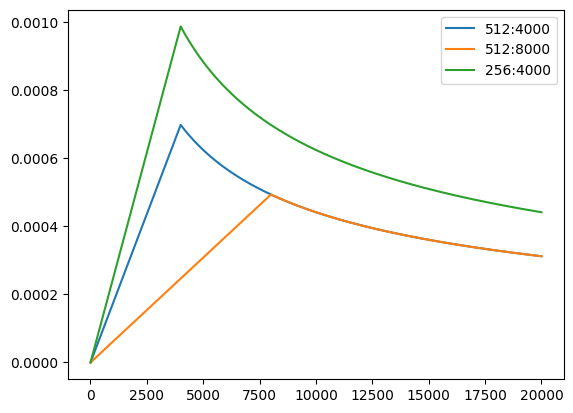

In [8]:
class NoamOpt:
    def __init__(self, vocab_size, factor, warmup, optimizer, **kwargs):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = vocab_size
        self._rate = 0

    def __rate__(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))

    def step(self):
        "Update parameters and rate"
        self._step += 1
        self._rate = self.__rate__()
        for p in self.optimizer.param_groups:
            p['lr'] = self._rate
        self.optimizer.step()
        
    def zero_grad(self):
        self.optimizer.zero_grad()

    
# plot NoamOpt
import matplotlib.pyplot as plt
import numpy as np

opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.__rate__(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

# Main

In [9]:
class Batch:
    """collect data in batch, used in collate_fn"""
    def __init__(self, src, tgt, src_key_padding_mask, tgt_key_padding_mask):
        self.src = src
        self.tgt = tgt
        self.src_key_padding_mask = src_key_padding_mask
        self.tgt_key_padding_mask = tgt_key_padding_mask
    
    def to(self, device):
        return Batch(self.src.to(device), self.tgt.to(device), self.src_key_padding_mask.to(device), self.tgt_key_padding_mask.to(device))

In [10]:
from tqdm import tqdm

import torch
import torch.nn as nn
import numpy as np
from torch.optim import AdamW
from torch.utils.data import DataLoader


def parse_args():
    """arguements"""
    config = {
        "batch_size" : 1024,
        "n_workers" : 0,
        "n_epochs" : 1,
        "datapath_config" : {
            "clean" : ["./data/clean/clean.en", "./data/clean/clean.zh"],
            "token" : "./token/data/train.json",
        },
        "spm_config" : {
            "vocab_size" : 8000,
            "dir" : "./token",
            "model_type" : "bpe",
            "nm_rule" : "nmt_nfkc_cf",
            "character_coverage" : 1,
            "input_sentence_size" : 1e6,
            "shuffle_input_sentence" : True,
            "pad_id" : 0,
            "unk_id" : 1,
            "bos_id" : 2,
            "eos_id" : 3,
        },
        "criterion_config" : {
            "smoothing" : 0.1,
        },
        "noamOpt_config" : {
            "factor" : 1,
            "warmup" : 1000,
        },
        "model_config" : {
            "pos_encode" : PositionalEncoding,
            "d_model" : 128,
            "nhead_encoder" : 2,
            "nhead_decoder" : 2,
            "encoder_layer" : 2,
            "decoder_layer" : 2,
        },
    }
    return config


def get_device():
    device = (
        "gpu" if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available()
        else "cpu"
    )
    return device

def main(
        batch_size,
        n_workers,
        n_epochs,
        datapath_config,
        spm_config,        
        criterion_config,
        noamOpt_config,
        model_config,
):
    logger = set_logger("s2s-transformer")

    device = get_device()
    logger.info(f"{device} is used.")

    vocab_size = spm_config['vocab_size']

    def collate_fn(batch):
        # src, tgt is tuple when using zip(*)
        src, tgt = zip(*batch)
        # turn src, tgt back to tensor
        src = torch.tensor(np.asarray(src))
        tgt = torch.tensor(np.asarray(tgt))        
        src_key_padding_mask = (src == spm_config['pad_id'])
        tgt_key_padding_mask = (tgt == spm_config['pad_id'])
        return Batch(src, tgt, src_key_padding_mask, tgt_key_padding_mask)
    
    train_loader, valid_loader, features_len = get_dataloader(datapath_config['token'], batch_size, n_workers, spm_config['pad_id'], collate_fn)
    logger.info("Training/Validating data loaded.")
    
    model = mk_model(vocab_size=vocab_size, batch_size=batch_size, length=features_len, **model_config).to(device)
    logger.info("Model created.")

    criterion = LabelSmoothingCrossEntropyLoss(vocab_size=vocab_size, padding_idx=spm_config['pad_id'], **criterion_config)
    optimizer = AdamW(params=model.parameters(), lr=0.0, betas=(0.9, 0.98), eps=1e-9)
    noamOpt = NoamOpt(vocab_size=vocab_size, optimizer=optimizer, **noamOpt_config)
    logger.info("Criterion set.")

    # --TODO--
    # training
    logger.info("===Start training===")
    for i in range(n_epochs):
        epoch_loss = 0.0
        model.train()
        for batch in tqdm(train_loader):
            batch = batch.to(device)
            preds = model(batch.src, batch.tgt, batch.src_key_padding_mask, batch.tgt_key_padding_mask)
            loss = criterion(preds, batch.tgt)
            loss.backward()
            noamOpt.step()
            noamOpt.zero_grad()
            epoch_loss += loss.item()
        """
        model.eval()
        for batch in tqdm(valid_loader):
            batch.to(device)
            with torch.no_grad():
                # ---TODO---:
                # validating
                ...
        """
        print(epoch_loss)


if __name__ == "__main__":
    main(**parse_args())
    

s2s-transformer [INFO] mps is used.
s2s-transformer [INFO] Training/Validating data loaded.
s2s-transformer [INFO] Model created.
s2s-transformer [INFO] Criterion set.
s2s-transformer [INFO] ===Start training===
  0%|          | 0/347 [00:03<?, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 5.09 GB, other allocations: 3.48 GB, max allowed: 9.07 GB). Tried to allocate 1.64 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).